To the Department of Housing and Urban Development,

The disparate impact cause of action was first ruled to arise under the Fair Housing Act in 1974 in United States v. City of Black Jack, and since then the 11 federal circuits to consider the question have universally agreed. This proposed rule change would trade the decades-long legally supported interpretation of the Fair Housing Act that establishes disparate impact as the method of determining discrimination with the discriminatory intent interpretation that was explicitly rejected by the lawmakers who created the Fair Housing Act. As Republican Senator Charles Percy said in 1968, when an amendment was proposed to add an intent requirement to the Fair Housing Act, "I maintain [such a] proof would be impossible to produce." 

If proving discriminatory intent was known to be impossible in 1968, it is especially so in 2019 when advances in algorithmic techniques and processing capabilities allow for far increased levels of intent obfuscation. These advanced algorithms provide housing service providers far greater capabilities of discriminating against protected classes by perpetuating and exacerbating historical discrimination that requires disparate impact analysis in order to expose policies and decisions that can cause additional illegal harm to protected classes.

Many other comments have gone into much further detail about the legal history that makes this proposed rule change in totality misguided, so I will instead focus on the proposed changes in paragraph (c)(2) of §100.500 that concern the use of algorithmic models as a defense against charges of violations of the Fair Housing Act.

   # I. Rationale against the proposed safe harbor protection

Providing safe harbor provisions enables discriminatory action because those safe harbor provisions by design do not address the impact of an algorithm or procedure, only the inputs and methods. The short-sighted nature of this proposed rule relies on the misguided notion that all potentially discriminatory practices or variables can be itemized and avoided. One of the fundamental strengths of machine learning techniques is that they can create models that establish interactions between variables in ways that more traditional algorithms do not, which makes many discriminatory actions impossible to predict. As designers of these algorithms know intimately, the most powerful tool for evaluating a model is by analyzing its outputs.

The proposed protection is one that in the still young field of FAT ML (fairness, accountability, and transparency in machine learning) is referred to as "fairness through blindness." This approach of trying to "de-bias" a model by not including certain variables that a designer wishes to avoid discriminating against is a common pitfall for inexperienced data scientists who fail to recognize the complex correlations of data. With a sufficiently large dataset it is not only possible to reverse engineer protected classes like race, gender, and disability, but should be expected. Machine learning techniques rely on levels of interactions between variables and how it chooses those interactions are almost incomprehensible to their creators, much less a layperson. Removing individual variables and proxies is a game of whack-a-mole that algorithms will always be thousands of steps ahead of any regulatory body.

Can one prove conclusively that "number of times voted recently" is not a proxy for race? Perhaps it isn't on its own, but a machine learning algorithm might draw a connection between that and number of moves in the past year and calls to emergency services, and a thousand other variables to create a model that discriminates based on race despite not explicitly being given racial characteristics during training. Fundamentally, a predictive machine learning algorithm uses past data to predict future events. If that past data includes discrimination, the algorithm will create a model that incorporates that discrimination. It is simply a much harder task to tune an algorithm to minimize this discrimination and does not occur unless a different cost function is chosen to optimize that incorporates avoiding discrimination as one of its goals. The market will optimize for discrimination, because designing an algorithm not to discriminate requires optimizing for another metric besides profit. If a company or landlord faces no accountability for enacting discrimination, they will dismiss attempts to consider the discriminatory effects of their work as a negative externality for which they have no responsibility.

Algorithms are not objective truths because they involve math. Designing, tuning, and training a model is an aggregate result of countless decisions by its creators. Even the construction of the question an algorithm is deployed to answer is a huge element of human influence on what the results will be. These are human decisions, even if they may be tool-assisted, and humans should be held accountable when their product and policies run afoul of the law. Algorithms provide a method of accelerating and magnifying systemic discrimination at a level of efficiency undreamt of by racist redliners of the 20th century. Without robust protections against the discriminatory effects of decisions made with machine learning tools, HUD will ensure that it will be a tool used to protect and enforce discrimination rather than one that could prevent and root out injustice.

   # II. Example of a discriminatory algorithm in practice

In order to more fully illustrate how “fairness through blindness” is an inadequate technique for eliminating bias, I have created a machine learning model that shows how an algorithm can still discriminate against protected classes even without including the protected class data as input. For this scenario, imagine a rental company wishes to measure the eviction risk of tenants coming from out of town in order to determine whether or not to approve them for housing. This company wants to avoid tenants coming from counties that are currently experiencing high eviction rates as they believe such tenants are more likely to have been evicted recently or could be moving for eviction-related reasons that they might not reveal in their application. I used all publicly available data to create a model that can predict this risk. County-level eviction data can be found from the Eviction Lab, which also provides data on population, percentage of renter occupied households, median rent, median household income, median property value, rent burden, and race percentages. I merged this with census data to include other potentially predictive information, including allocation of private and public health insurance, household type, and means of transportation to work. 

Run the following cell (click inside it and press SHIFT+ENTER) in order to initialize this notebook, import the input data, and clean it for modeling.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings
from scipy.stats import pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
shap.initjs()

df = pd.read_csv('data/US/counties.csv')
df = df.rename(columns = lambda x: x.lower().replace('-','_'))
df_16 = df[df.year == 2016]
df_16.dropna(inplace=True)
df_16.reset_index(inplace = True)

# Incorporate public health insurance
df_pubhealth = pd.read_csv('data/census/ALLOCATION OF PUBLIC HEALTH INSURANCE/ACS_16_5YR_B992703_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_pubhealth.columns = df_pubhealth.columns.droplevel(0)
renames = {}
for col in df_pubhealth.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_pubhealth = df_pubhealth.rename(columns = renames)
drops = ['Id','Geography','Total','Total_No_public_coverage_items_allocated']
df_pubhealth.drop(drops, axis=1, inplace=True)
df_pubhealth.dropna(inplace=True)

df_16 = pd.merge(df_16, df_pubhealth, how = 'inner', left_on= 'geoid', right_on= 'Id2')
df_16['pct_public_health_insurance'] = df_16['Total_One_or_more_public_coverage_items_allocated']/df_16['population']
df_16.drop('Total_One_or_more_public_coverage_items_allocated', axis=1, inplace=True)

# Incorporate private health insurance
df_privhealth = pd.read_csv('data/census/ALLOCATION OF PRIVATE HEALTH INSURANCE/ACS_16_5YR_B992702_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_privhealth.columns = df_privhealth.columns.droplevel(0)
renames = {}
for col in df_privhealth.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_privhealth = df_privhealth.rename(columns = renames)
drops = ['Id','Geography','Total','Total_No_private_health_insurance_items_allocated']
df_privhealth.drop(drops, axis=1, inplace=True)
df_privhealth.dropna(inplace=True)

df_16 = pd.merge(df_16, df_privhealth, how = 'inner', left_on= 'geoid', right_on= 'Id2')
df_16['pct_private_health_insurance'] = df_16['Total_One_or_more_private_health_insurance_items_allocated']/df_16['population']
df_16.drop('Total_One_or_more_private_health_insurance_items_allocated', axis=1, inplace=True)

# Incorporate household type
df_household = pd.read_csv('data/census/HOUSEHOLD TYPE/ACS_16_5YR_B11001_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_household.columns = df_household.columns.droplevel(0)

renames = {}
for col in df_household.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_household = df_household.rename(columns = renames)

drops = ['Id','Geography']
for col in df_household.columns:
    if 'Margin' in col:
        drops.append(col)
df_household.drop(drops, axis=1, inplace = True)
df_household.dropna(inplace=True)
df_household.rename(columns={'Family_households_Other_family_Female_householder,_no_husband_present':
                           'Female_householder,_no_husband_present'}, inplace=True)

df_htemp = df_household.drop(['Id2','Total'],axis=1).div(df_household['Total'],axis=0)
df_htemp['Id2'] = df_household['Id2']
df_16 = pd.merge(df_16, df_htemp, how = 'inner', left_on= 'geoid', right_on= 'Id2')

# Incorporate transportation by sex
df_transport = pd.read_csv('data/census/SEX OF WORKERS BY MEANS OF TRANSPORTATION TO WORK/ACS_16_5YR_B08006_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transport.columns = df_transport.columns.droplevel(0)

renames = {}
for col in df_transport.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transport = df_transport.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transport.columns:
    if 'Margin' in col:
        drops.append(col)
df_transport.drop(drops, axis=1, inplace = True)
df_transport.dropna(inplace=True)

df_ttemp = df_transport.drop(['Id2','Total'],axis=1).div(df_transport['Total'], axis=0)
df_ttemp['Id2'] = df_transport['Id2']
df_16 = pd.merge(df_16, df_ttemp, how = 'inner', left_on= 'geoid', right_on= 'Id2')

# Init train and test sets
y = df_16['eviction_filing_rate']
X = df_16.drop(['index','year','population','renter_occupied_households',
               'eviction_filings','evictions','eviction_rate', #'low_flag', 'imputed', 'subbed',
               'eviction_filing_rate','Id2_x','Id2_y'], axis=1)
random_state = 42
X_train_geo, X_test_geo, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train = X_train_geo.drop(['geoid','name','parent_location'], axis=1)
X_test = X_test_geo.drop(['geoid','name','parent_location'], axis=1)

/Users/marcloeffke/anaconda3/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Predict evictions with protected class variables included

After collecting the data, I chose a specific type of machine learning algorithm called XGBoost to predict the eviction rate for a given county a potential tenant last lived. I chose this algorithm for its proven effectiveness for modeling general regression problems, and because as a tree ensemble method it has the highly desirable property of working well with Shapley additive explanation values (SHAP). SHAP values can help expose the black box of why a machine learning algorithm makes the prediction it does by generating explanations alongside its predictions. These can give an analyst insight into both how any input variable influenced a specific prediction and how a model generally weighs the importance and direction of influence of a variable.

I then created two versions of this model - one in which protected class information is included in the inputs and one in which all protected class information has been removed. Starting with the version that includes protected class information, one can see how SHAP values can help reveal the inner workings of a model.

Run the following cell in order to initialize the model.

In [2]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.5,
    "max_depth": 3,
    "objective": "reg:linear",
    'min_samples_leaf': 30,
    'min_samples_split': 100,
    'n_estimators': 80,
    "silent": 1,
    "base_score": np.mean(y_train),
    "eval_metric": "rmse",
    'max_features': 'sqrt'
}

model = xgb.train(params, d_train, 10000, [(d_train,'train'),(d_test,'valid')], 
                  early_stopping_rounds=200, verbose_eval=1000)

# Compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create force plot for Macon County
shap.force_plot(explainer.expected_value, shap_values[60,:], X_test.iloc[60,:])

[0]	train-rmse:4.36792	valid-rmse:3.45373
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[1]	train-rmse:3.80273	valid-rmse:3.27024



The force plot above reveals the influence of each predictive variable on the output value (predicted eviction rate) for a tenant moving from Macon County, Alabama.

The plot shows that the variable that had the largest positive predictive value is the high percentage of African Americans in the county (80.86% of the county), followed by the high percentage of female householders with no husband present (23.79% of the county). Both race and sex are protected classes, so the fact that the two variables that most increased the eviction prediction rate explicitly include protected class information suggests that this model is discriminatory.

However, looking at the predictive influence of variables in one prediction is not enough to determine the level of discrimination within the model. XGBoost, like many machine learning models, is non-monotonic, which means that the relationship between an input variable and the output variable can vary in both magnitude and direction. In order to explore the predictive importance and general direction of effect of the input variables, one can explore a summary plot of the SHAP values on a test set. In the summary plot below all the SHAP values for a single feature are plotted on a row, where the x-axis is the SHAP value. By doing this for all features, we see which features strongly drive the model's prediction, and which only affect the prediction a little. Note that when points don't fit together on the line they pile up vertically to show density.

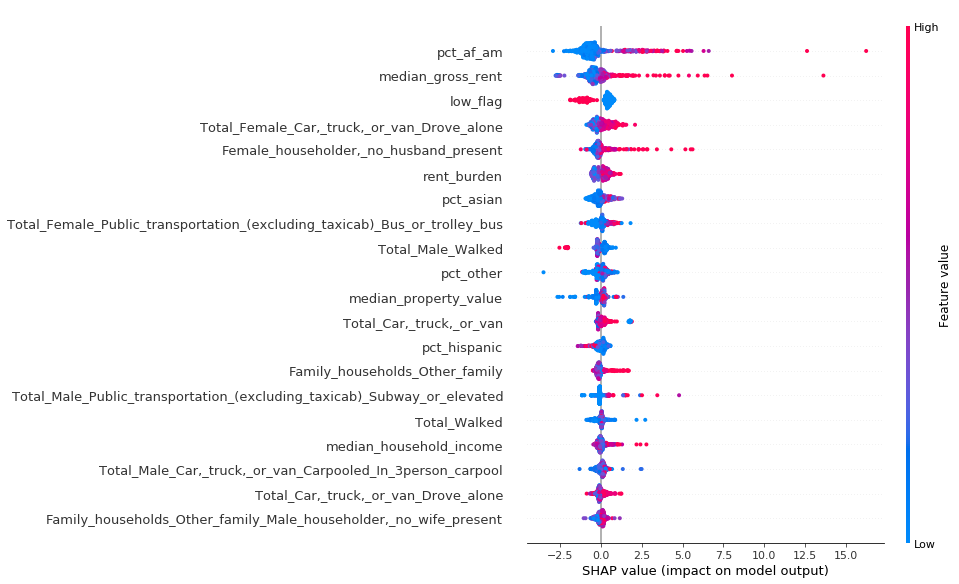

In [3]:
# Create summary plot of SHAP values for model with protected class information
shap.summary_plot(shap_values, X_test)

The summary plot shows that the feature with the most predictive importance is the percentage of African Americans in a county, with higher percentages generally increasing the prediction of eviction rates and lower percentages generally decreasing the prediction of eviction rates. Out of 77 input variables, 11 out of the top 20 features with the most predictive importance include protected class information. This suggests that the model is highly discriminatory against protected classes, and any housing decisions made using this model would be illegal under the Fair Housing Act.

Now I will show a similar analysis on an XGBoost model trained using identical hyperparameters that does not include protected class information in the input variables.

Run the cell below to create this model and create the force plot for the same prospective tenant coming from Macon County.

In [4]:
Xp = X.drop(['pct_white','pct_af_am','pct_hispanic','pct_am_ind','pct_asian','pct_nh_pi',
            'pct_multiple','pct_other','Family_households_Other_family_Male_householder,_no_wife_present',
            'Family_households_Other_family_Male_householder,_no_wife_present',
            'Female_householder,_no_husband_present',
            'Total_Male','Total_Male_Car,_truck,_or_van','Total_Male_Car,_truck,_or_van_Drove_alone',
            'Total_Male_Car,_truck,_or_van_Carpooled','Total_Male_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Male_Car,_truck,_or_van_Carpooled_In_3person_carpool',
       'Total_Male_Car,_truck,_or_van_Carpooled_In_4ormoreperson_carpool',
       'Total_Male_Public_transportation_(excluding_taxicab)',
       'Total_Male_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus',
       'Total_Male_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico)',
       'Total_Male_Public_transportation_(excluding_taxicab)_Subway_or_elevated',
       'Total_Male_Public_transportation_(excluding_taxicab)_Railroad',
       'Total_Male_Public_transportation_(excluding_taxicab)_Ferryboat',
       'Total_Male_Bicycle', 'Total_Male_Walked',
       'Total_Male_Taxicab,_motorcycle,_or_other_means',
       'Total_Male_Worked_at_home', 'Total_Female',
       'Total_Female_Car,_truck,_or_van',
       'Total_Female_Car,_truck,_or_van_Drove_alone',
       'Total_Female_Car,_truck,_or_van_Carpooled',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_3person_carpool',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_4ormoreperson_carpool',
       'Total_Female_Public_transportation_(excluding_taxicab)',
       'Total_Female_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus',
       'Total_Female_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico)',
       'Total_Female_Public_transportation_(excluding_taxicab)_Subway_or_elevated',
       'Total_Female_Public_transportation_(excluding_taxicab)_Railroad',
       'Total_Female_Public_transportation_(excluding_taxicab)_Ferryboat',
       'Total_Female_Bicycle', 'Total_Female_Walked',
       'Total_Female_Taxicab,_motorcycle,_or_other_means',
       'Total_Female_Worked_at_home'], axis=1)
Xp_train_geo, Xp_test_geo, yp_train, yp_test = train_test_split(Xp, y, test_size=0.2, random_state=random_state)
Xp_train = Xp_train_geo.drop(['geoid','name','parent_location'], axis=1)
Xp_test = Xp_test_geo.drop(['geoid','name','parent_location'], axis=1)

dp_train = xgb.DMatrix(Xp_train, label=yp_train)
dp_test = xgb.DMatrix(Xp_test, label=yp_test)

paramsp = {
    "eta": 0.5,
    "max_depth": 3,
    "objective": "reg:linear",
    'min_samples_leaf': 30,
    'min_samples_split': 100,
    'n_estimators': 80,
    "silent": 1,
    "base_score": np.mean(yp_train),
    "eval_metric": "rmse",
    'max_features': 'sqrt'
}

modelp = xgb.train(paramsp, dp_train, 10000, 
                  [(dp_train,'train'),(dp_test,'valid')], early_stopping_rounds=200, verbose_eval=1000)

# Compute the SHAP values for every prediction in the validation dataset
explainerp = shap.TreeExplainer(modelp)
shap_valuesp = explainerp.shap_values(Xp_test)

# Create force plot for Macon County
shap.force_plot(explainerp.expected_value, shap_valuesp[60,:], Xp_test.iloc[60,:])

[0]	train-rmse:4.53494	valid-rmse:3.47532
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[7]	train-rmse:3.06481	valid-rmse:3.14848



This force plot shows that the majority of the positive predictive force is provided by the Family_households_Other_family, a variable that captures households that do not fall under census definitions of “traditional” households. Female householders with no husband present, which was the fifth most predictively important variable in the previous model, would be a subset of this variable. Again, due to the non-monotonic property of XGBoost, the predictive importance of a variable across the model can best be seen with a summary plot.

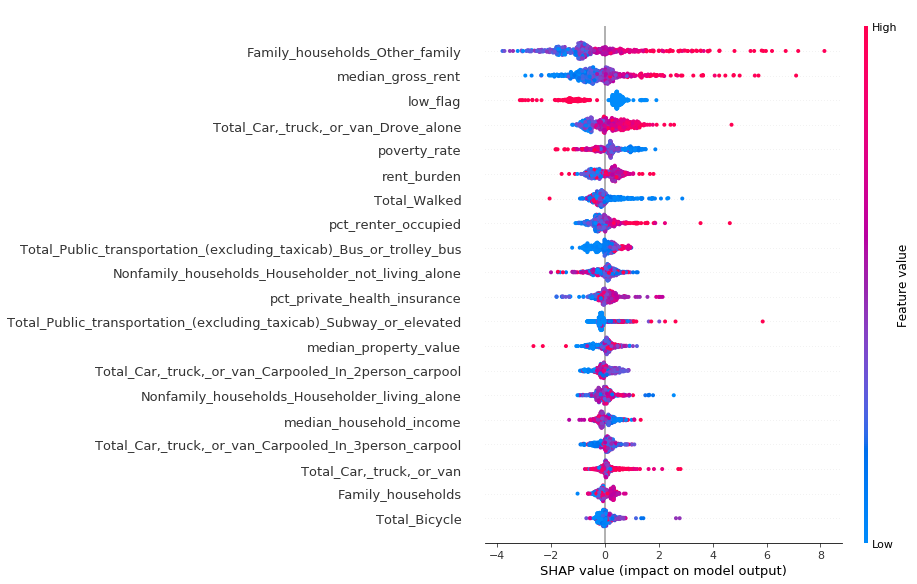

In [5]:
# Create summary plot of SHAP values for model with no protected class information included
shap.summary_plot(shap_valuesp, Xp_test)

This plot shows that Family_households_Other_family is indeed the most predictively important variable for the model, followed by median rent. Since no protected class information has been explicitly included in the input variables, there is no method of determining if this model is discriminatory without analyzing the impacts of its prediction decisions on protected classes. Instead, disparate impact analysis is required, which can be shown for both models. For the model with protected class information, the Pearson correlation coefficient between “Percentage African American” and eviction rate prediction is 0.425, with a p-value of 2.48 x 10<sup>-23</sup>, which implies a strong statistically significant positive relationship between the African American makeup of a county and the predicted eviction rate. For the model without protected class information, the Pearson correlation coefficient between “Percentage African American” and eviction rate prediction is 0.379, with a p-value of 1.65 x 10<sup>-18</sup>, which also implies a strong statistically significant positive relationship between the African American makeup of a county and the predicted eviction rate.

These findings should shock the makers of this proposed rule, as the model created without any protected class inputs has been shown to result in discriminatory predictions against protected classes regardless, with a correlation magnitude very similar to the model that included the protected class information. The predictive power of the machine learning model meant it was able to identify the underlying pattern of historical racial discrimination in housing in the US and dutifully reproduced it, meaning any decisions a rental company would make using this model as an influence would be racially motivated. How the model can still uncover this information about protected classes can be examined more clearly using the table of Pearson correlations below.


In [7]:
# Include prediction data in dataframe with GEOID included
X_test_geo['predictions_with_all_inputs'] = model.predict(d_test)
X_test_geo['predictions_exclude_protected_classes'] = modelp.predict(dp_test)

# Create correlation dataframe
corr_X = X_test_geo[['predictions_with_all_inputs','predictions_exclude_protected_classes',
                           'pct_white', 'pct_af_am','Female_householder,_no_husband_present',
                           'Family_households_Other_family','poverty_rate',
                           'median_gross_rent','median_household_income', 'rent_burden', 
                           'Total_Female_Car,_truck,_or_van_Drove_alone',
                           'Total_Car,_truck,_or_van_Drove_alone', 'pct_renter_occupied',
                          'Total_Walked']].corr()
corr_X

,predictions_with_all_inputs,predictions_exclude_protected_classes,pct_white,pct_af_am,"Female_householder,_no_husband_present",Family_households_Other_family,poverty_rate,median_gross_rent,median_household_income,rent_burden,"Total_Female_Car,_truck,_or_van_Drove_alone","Total_Car,_truck,_or_van_Drove_alone",pct_renter_occupied,Total_Walked
predictions_with_all_inputs,1.000000,0.704410,-0.295243,0.425246,0.393049,0.355809,0.072594,0.463457,0.181565,0.337570,0.178877,0.117659,0.356323,-0.208609
predictions_exclude_protected_classes,0.704410,1.000000,-0.298612,0.379181,0.434122,0.415396,0.125029,0.381589,0.089200,0.295055,0.262567,0.262649,0.329600,-0.280863
pct_white,-0.295243,-0.298612,1.000000,-0.594461,-0.648738,-0.624488,-0.433035,-0.262969,0.111023,-0.201014,-0.065284,-0.016718,-0.390440,0.167583
pct_af_am,0.425246,0.379181,-0.594461,1.000000,0.671007,0.591742,0.428628,0.082839,-0.258420,0.353518,0.341358,0.136790,0.222272,-0.185920
"Female_householder,_no_husband_present",0.393049,0.434122,-0.648738,0.671007,1.000000,0.960198,0.700626,0.051760,-0.376202,0.438286,0.422679,0.272188,0.334680,-0.395469
Family_households_Other_family,0.355809,0.415396,-0.624488,0.591742,0.960198,1.000000,0.693404,0.047270,-0.362772,0.415555,0.422448,0.303509,0.313471,-0.422034
poverty_rate,0.072594,0.125029,-0.433035,0.428628,0.700626,0.693404,1.000000,-0.338254,-0.742101,0.411684,0.230318,0.098425,0.267717,-0.165273
median_gross_rent,0.463457,0.381589,-0.262969,0.082839,0.051760,0.047270,-0.338254,1.000000,0.675374,0.195831,-0.141074,-0.083765,0.299359,-0.054594
median_household_income,0.181565,0.089200,0.111023,-0.258420,-0.376202,-0.362772,-0.742101,0.675374,1.000000,-0.314825,-0.217185,-0.045292,-0.063755,0.013118
rent_burden,0.337570,0.295055,-0.201014,0.353518,0.438286,0.415555,0.411684,0.195831,-0.314825,1.000000,0.304249,0.139248,0.217143,-0.210450


When the protected class variables were removed from the model inputs, the predictive importance of Family_households_Other_family became much stronger. The correlation table shows that this variable has a positive correlation with both pct_af_am and Female_householder,_no_husband_present. Similarly, poverty_rate and rent_burden also have a high positive correlation with pct_af_am and Female_householder,_no_husband_present. These correlations show potential paths for a model to recreate underlying race and sex discrimination in a dataset without being provided race and sex inputs through combinations of associations with other provided variables, even if no one variable is a proxy for race or sex data.

There are many ways to improve this model, and many different methods to improve its predictive power or adjust the eviction prediction output to account for income and other potentially confounding factors. But crucially, none of this is required under the proposed rule. As this model follows all the requirements in the proposed rule that it be “empirically derived, its inputs are not substitutes for a protected characteristic, the model is predictive of risk or other valid objective, and is a demonstrably and statistically sound algorithm.” No further efforts are legally required to eliminate discrimination in this model, and a member of a protected class that was discriminated against by a housing service provider that employed this model as a reason for denial of service would have no possibility of legal recourse.

I have set up this algorithm to allow for explanation by design by generating the SHAP values alongside the predictive output. Any sufficiently motivated and skilled person could find out how a variable impacts the decision of the model. These SHAP values for the model that included protected class data as an input also provide a potential avenue for correcting against discrimination from that model, and could be a helpful starting point for any designer that is incentivized to do so. However, the majority of models do not have this quality and instead require a black box explanation - where the understanding of the inner workings of the model have to be derived from its outputs. My example shows how an algorithm can follow this proposed rule change and still easily discriminate against protected classes. This makes the obvious case that the proposed rule does not protect against discrimination. However it also implies that any rule change that could hold those who use algorithm influenced decision-making accountable must allow for black box explanations that determine an algorithm's decision-making based on its impact, as that would be the only method available to any plaintiff without easy access to a proprietary algorithm.

# III. Implications and proposed changes to the rule

I have shown definitively a model where no individual input is a substitute for a protected characteristic that is still able to derive those protected characteristics in aggregate from the other inputs, so allowing a defendant to dismiss a claim by invoking solely the inputs is absurd. This is a relatively simple model with a relatively small amount of publicly accessible data compared to what a housing service provider could have access too, so the potential for more completely recreating protected class variables and discriminating against them is even greater than what I have demonstrated. Fairness through blindness does not stop a model from discriminating, and it is easy to imagine a model with an even richer dataset that includes more feature variables to shrink the predictive difference between a model that does include protected class information explicitly and one that removes it. 

The only complete approach to combat discrimination is to strengthen the ability to find fault using disparate impact analysis. Housing service providers should absolutely be held responsible for discriminatory practices as they should have some incentive for finding and rooting out discriminatory practices on their own, and have a robust accountability process with teeth to punish them when they don't in order to redress the impact of their decisions. Without being able to use statistics to explore where there is systemic injustice and law-breaking, companies will be able to enact discriminatory practices without any counterbalance at all.
The proposed rule would allow for the new efficiency of machine learning algorithms to rampage across our most vulnerable populations while hamstringing attempts to use those same techniques as a tool to expose the magnitude of these evils.

As myself and many others have detailed, the proposed rule change would do irreparable harm to our country and citizens and undo the crucial protections for our people provided under the Fair Housing Act. If the Department of Housing and Urban Development truly wishes to create a new ruling that updates the interpretation of the Fair housing Act that provides the required legal protections against housing discrimination for all citizens as well as assist housing service providers with following the law and avoiding discrimination, I propose the following three suggestions in order of importance:


1. Stop this proposed rule change as its designated goal of shielding entities engaging in practices that have discriminatory effects is in direct contradiction with HUD's necessary role of preventing discriminatory housing practices and upholding the Fair Housing Act.


2. Propose new rule changes that instead reinforce and clarify that housing service providers will continue to be liable for discriminatory practices and reinforce legal pathways for recourse for victims of housing discrimination.


3. In consultation with domain experts, create tools and guidelines for assisting housing service providers with identifying practices and algorithms that have disparate impact and correcting their discriminatory biases.


The only effective algorithmic safe harbor that a defendant should be able to invoke is if they can prove their algorithms has led to outcomes that are statistically non-discriminatory. The proposed safe harbor ruling attempts to provide that protection from just limiting the inputs of the protected class, but this approach does nothing more than shield discriminatory actors and perpetuates their harmful discrimination. A rule looking to uphold the law must instead look to the outputs, which is to use the method of showing disparate impact that has been the standard until now.

Fundamentally, any proposed rule should instead be structured to require industry standards to not discriminate with the output of their models, rather than encourage the creation and defense of discriminatory standards. Burden of proof must remain with the defendant to show how they attempted to avoid discriminating against protected classes, as the defendant is the entity with access to the algorithms and the reasoning employed in their development. For a plaintiff to be required to prove before a case has gone past the pleading stage that a defendant engaged in discriminatory practices aided by algorithm, without access to the proprietary algorithm and unable to use discriminatory impact as evidence, is an all but impossible task and one that perverts the letter and intent of the Fair Housing Act. The power of machine learning and other advanced algorithms provides our nation with unprecedented opportunities for identifying discrimination and protecting our citizens. I hope HUD can use these emerging capabilities to uphold the law, defend our rights, and protect the most vulnerable in our society. Please do not enshrine in policy a new era of algorithmically assisted discrimination, which this proposed ruling would do.

Sincerely,  
Marc Loeffke
